![](https://img4.cityrealty.com/neo/i/p/mig/airbnb_guide.jpg)

>  **Loading of Libraries**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

#This notebook is inpired from the work done by: Erik Bruin in the following link
#https://www.kaggle.com/erikbruin/airbnb-the-amsterdam-story-with-interactive-maps
#Also Please upvote the great work done by Erik 



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium import plugins
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
from scipy.stats import pearsonr

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png


* * **Data Loading into a dataset**



In [3]:
#Loading of Files<a></a>
dataset = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
dataset.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Now we need to check how many rows and columns the dataset is having. It is also necessary to check how many unique values are present for each column. For this we will also use the nunique.

So we have the 48895 rows and 16 columns.

In [4]:
print('\nRows : ',dataset.shape[0])
print('\nColumns :', dataset.shape[1])
print('\nColumns:',dataset.columns.to_list())
print(' \nUnique:\n',dataset.nunique())




Rows :  48895

Columns : 16

Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
 
Unique:
 id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64


**Plotting the dataset in a map **

Since according to the dataset we have been provided with the latitude and longitude so we will use folium libraries to present the data into a map. This map can be zoomed and the individual locations can be viewed in detail. I have used the zoom start to 9 so that the clusters can be visible.

In [5]:

Long=-73.80
Lat=40.80
locations = list(zip(dataset.latitude, dataset.longitude))

map1 = folium.Map(location=[Lat,Long], zoom_start=9)
FastMarkerCluster(data=locations).add_to(map1)
map1






**For Nan Values in column reviews_per_month,replacing Nan with 0 **

In [6]:
dataset.fillna({'reviews_per_month':0},inplace=True)

**Scatter Plot to show the neighbourhood group based on Latitude and Longitude**

We will plot the same latitude and longitude in  a scatter plot to have the cluster of the location, the same we did with the folium maps.

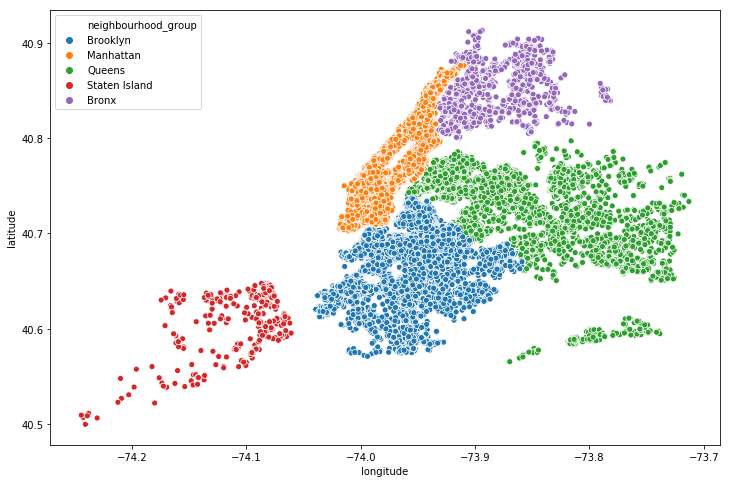

In [7]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=dataset.longitude,y=dataset.latitude,hue=dataset.neighbourhood_group)
plt.show()

**Unique Values**

It is very important to understand and analyze the Unique values, this gives a lot of insight to the data and the user preference for a particular choice. We will take Room Type and Neighbourhood group

From the below, we have 3 types of room in the dataset and 5 different neighbourhood group. In the next section we will explore more on these two categories to understand the user distribution.

In [8]:
print('Unique value for room_type are :',dataset.room_type.unique())
print('Unique value for neighbourhood_group are :',dataset.neighbourhood_group.unique())

Unique value for room_type are : ['Private room' 'Entire home/apt' 'Shared room']
Unique value for neighbourhood_group are : ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


**Room Types and Neighbourhood Group**

We will first check the distribution of the room type by grouping the data. From the below its clear the Apartment and Private data is more than that of shared rooms. 
In general, Shared rooms costs less and can be very useful for travellers who moves from one city to another city quite frequently. Though the shared rooms data is less, we will still try to uncover as much details as we can.


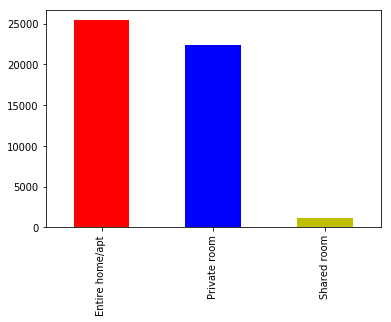

In [9]:
dataset['room_type'].value_counts().plot(kind='bar',color=['r','b','y'])
plt.show()


**Top 10 Apartment listings**

Below i am displaying the Entire Home/Apartment renting and it looks odd that Sonder(NYC) have itself is too high. We will also list out only the details for the user if they are genuine hotels or there is any discrepancy in the data. We will use the latitude and longitude of the data to find out.



In [10]:
apt = dataset[dataset['room_type']=='Entire home/apt']
list_apt = apt.groupby(['host_id','host_name','neighbourhood','neighbourhood_group']).size().reset_index(name='apartment').sort_values(by=['apartment'],ascending=False)
list_apt.head(10)





,host_id,host_name,neighbourhood,neighbourhood_group,apartment
20211,219517861,Sonder (NYC),Financial District,Manhattan,210
6449,7503643,Vida,Greenpoint,Brooklyn,52
8430,12243051,Sonder,Financial District,Manhattan,51
20214,219517861,Sonder (NYC),Murray Hill,Manhattan,50
19900,205031545,Red Awning,Midtown,Manhattan,49
17832,120762452,Stanley,Murray Hill,Manhattan,49
12273,30283594,Kara,Hell's Kitchen,Manhattan,41
17451,107434423,Blueground,Chelsea,Manhattan,37
12275,30283594,Kara,Midtown,Manhattan,33
17628,113805886,Yaacov,Upper East Side,Manhattan,33


**Lets see the Sonder (NYC) **

Seeing the below latitude and longitude it is clear that it is in the same building.

In [11]:
sonder_data = dataset[dataset['host_name']=='Sonder (NYC)']
sonder_data_by = sonder_data[['host_id','host_name','neighbourhood','latitude','longitude']]
sonder_data_by.head(5)

,host_id,host_name,neighbourhood,latitude,longitude
38293,219517861,Sonder (NYC),Financial District,40.70637,-74.00645
38294,219517861,Sonder (NYC),Financial District,40.70771,-74.00641
38588,219517861,Sonder (NYC),Financial District,40.70743,-74.00443
39769,219517861,Sonder (NYC),Murray Hill,40.74792,-73.97614
39770,219517861,Sonder (NYC),Murray Hill,40.74771,-73.97528


**Top 10 Private room**

We will do it for both Private room and Shared room and also will check for the top hoteliers if it is the same location or it is spread out.

In [12]:
private = dataset[dataset['room_type']=='Private room']
list_private = private.groupby(['host_id','host_name','neighbourhood']).size().reset_index(name='private').sort_values(by=['private'],ascending=False)
list_private.head(10)

,host_id,host_name,neighbourhood,private
15261,190921808,John,Hell's Kitchen,44
14025,137358866,Kazuya,Woodside,35
16301,238321374,Eyal,Upper West Side,32
15984,224414117,Gabriel,Hell's Kitchen,30
16035,226410657,Nina,Bedford-Stuyvesant,26
16144,230192510,Zach,Fort Greene,25
16386,242962235,Yuval,Ridgewood,23
16539,252604696,Erin,Chelsea,20
15761,216235179,Nina,Bushwick,17
14024,137358866,Kazuya,Sunnyside,17


**Location wise Private room**

In [13]:
private_data = dataset[dataset['host_name']=='John']
private_data_by = private_data[['host_id','host_name','neighbourhood','latitude','longitude']]
private_data_by.head()

,host_id,host_name,neighbourhood,latitude,longitude
0,2787,John,Kensington,40.64749,-73.97237
429,715807,John,Greenwich Village,40.72831,-74.00177
620,1229984,John,Long Island City,40.74581,-73.95295
991,1488809,John,Bushwick,40.70339,-73.92945
1141,2397411,John,Clinton Hill,40.68545,-73.96534


**Shared Room Exploration**

In [14]:
private = dataset[dataset['room_type']=='Shared room']
list_private = private.groupby(['host_id','host_name','neighbourhood']).size().reset_index(name='shared').sort_values(by=['shared'],ascending=False)
list_private.head(10)

,host_id,host_name,neighbourhood,shared
339,39528519,Max,Lower East Side,23
529,119669058,Melissa,Bedford-Stuyvesant,18
651,201015598,Anchor,Bedford-Stuyvesant,17
618,175730239,Baboucarr,Sunnyside,10
663,209386156,Abraham,East Harlem,9
727,253906467,Erik,Hell's Kitchen,9
686,223087887,Jess & Ana,Corona,8
714,248161322,Sergii,Bushwick,8
292,30509656,Orit,Port Morris,8
635,187975743,R.Henry,Hell's Kitchen,8


> **Exploration of Neighbourhood Group*

Let's explore the neighbourhood group now to see the data distribution. From the below it looks like Manhattan and Brooklyn has more number of listing that the Queens,Bronx and Staten island.


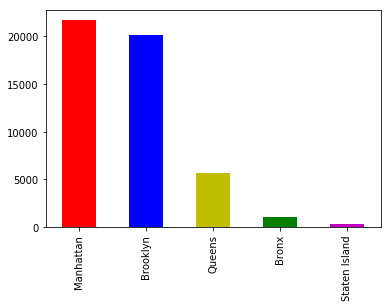

In [15]:
dataset['neighbourhood_group'].value_counts().plot(kind='bar',color=['r','b','y','g','m'])
plt.show()

In [16]:
private = dataset[dataset['neighbourhood_group']=='Manhattan']
list_private = private.groupby(['host_id','host_name','neighbourhood','neighbourhood_group']).size().reset_index(name='count').sort_values(by=['count'],ascending=False)
list_private.head(10)

,host_id,host_name,neighbourhood,neighbourhood_group,count
15621,219517861,Sonder (NYC),Financial District,Manhattan,218
5701,12243051,Sonder,Financial District,Manhattan,51
15624,219517861,Sonder (NYC),Murray Hill,Manhattan,50
13768,120762452,Stanley,Murray Hill,Manhattan,50
15380,205031545,Red Awning,Midtown,Manhattan,49
15150,190921808,John,Hell's Kitchen,Manhattan,46
8892,30283594,Kara,Hell's Kitchen,Manhattan,41
13463,107434423,Blueground,Chelsea,Manhattan,37
13622,113805886,Yaacov,Upper East Side,Manhattan,33
8894,30283594,Kara,Midtown,Manhattan,33


**Price Exploration**

We will check if there is any null value presentin the price column and from the below, it looks like we don't have any null value to take care of.


In [17]:
dataset.price.isna().sum()

0

Let's have a quick summary of the price data. In according to the summary statistics it is clear that the Price ranges from $0-$180. But there also exists price which has a maximum of $10000. This we cannot discard as an outlier because there are many scenarios in which price differs. The price varies on different factors which includes location,room type, neighbourhood , season etc. 
Also, we can see from the below there are few few values with 0, which can be due to dynamic pricing or the willingness of not to share the price with the Airbnb. 

We  also plot a boxplot to understand how the data is spread out for high ranges for the price irrespective of region.

In [18]:
dataset['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

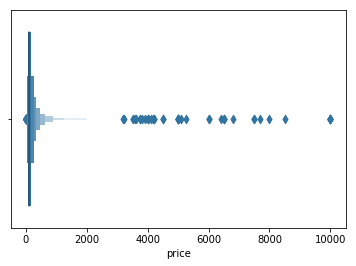

In [19]:
figsize=(12,8)
sns.boxenplot(x='price',data=dataset)


**Average room rent for locality**

For any traveller, the most important thing is the price since this sets the budget of his/her trip. So in the below we will figure out what is the average price per night. We will check for different room type and based on neighbourhood group to figure out what is the average per night stay. Staying at a Apartment is always an expensive stay than shared room/private rooms for any location. This is so because  Entire room is rented out by family for nice stay where privacy is also one of the major factor. Whereas Stay at Shared rooms are being preferred by travellers who generally don't wish to stay for long time at a particular place and moves around places quickly.

So looking at the  plot it is clear :

a. Shared room at staten Island is the most cheapest stay per night whereas Renting a Entire apartment/Home at Manhattan per night is the most expensive.

b. Average price for Private room is also considerably expensive at manhattan so is the shared room at Manhattan is expensive than other private rooms of the neighbourhood. This clearly states that Manhattan is the expensive stay than any other locality.

c. Bronx is the most cheapest stay in terms of neighbourhood group comparison in respect to room type.

d. Though Shared room at Staten Island is the cheapest whereas Apartment renting is not cheapest at Staten Island. This can be due to the location of a perfect gateway from the rush of the city for a quality time with family get together , let me know what you think :).

We will also list out the average price for each type of room per neighbourhood so that tourists can plan based on the budget.



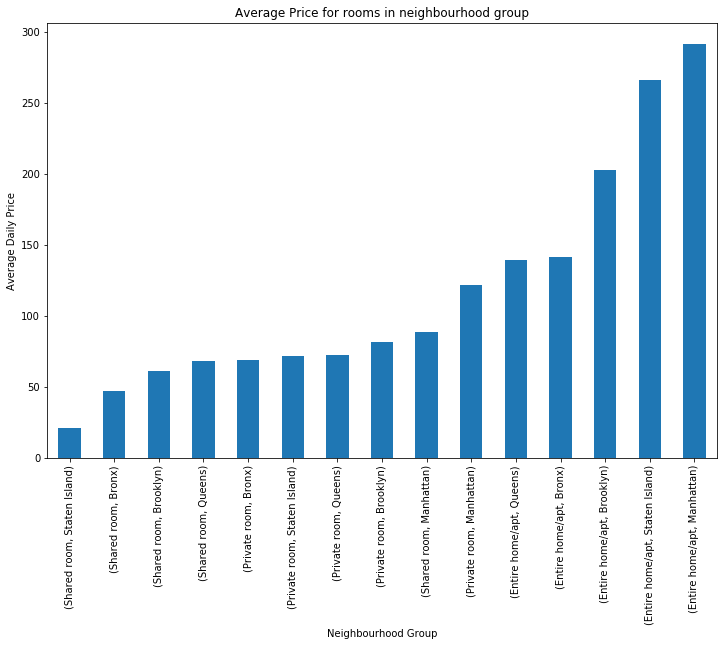

List of Average Price per night based on the neighbourhood group


price
room_type       neighbourhood_group            
Entire home/apt Queens               139.036260
                Bronx                141.541176
                Brooklyn             202.895245
                Staten Island        266.205128
                Manhattan            291.784595
Private room    Bronx                 69.025862
                Staten Island         71.394366
                Queens                72.454958
                Brooklyn              81.713284
                Manhattan            121.434183
Shared room     Staten Island         21.000000
                Bronx                 46.711111
                Brooklyn              60.921212
                Queens                68.459459
                Manhattan             88.462898

In [20]:
dataset.head()
plt.figure(figsize=(12,8))
df = dataset[dataset['minimum_nights']==1]
df1 = df.groupby(['room_type','neighbourhood_group'])['price'].mean().sort_values(ascending=True)
df1.plot(kind='bar')
plt.title('Average Price for rooms in neighbourhood group')
plt.ylabel('Average Daily Price')
plt.xlabel('Neighbourhood Group')
plt.show()
print('List of Average Price per night based on the neighbourhood group')
pd.DataFrame(df1).sort_values(by='room_type')



**Expensive Neighbourhood **

Till so far we have checked on the location group, but we have not came across each neighbourhood. This is very much important in terms of price to understand which locality has the highest price margin in terms of night being spend by traveller. Let's dig further to understand further.

So we will now plot the most expensive neighbourhood, and we will plot only Top 15 neighbourhood and Bottom 15 with respect to average price. This will help a traveller to choose the appropriate neighbourhood based on his budget.

So according to the below plot Fort Wadsworth is the most expensive in terms of neighbourhood. Whereas Bull's head locality is the least expensive to stay.


Top 20 most expensive locality in Airbnb listing are :


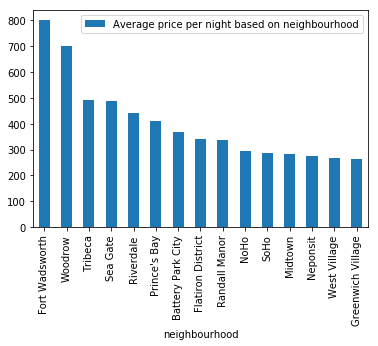

,Average price per night based on neighbourhood
neighbourhood,
Fort Wadsworth,800.000000
Woodrow,700.000000
Tribeca,490.638418
Sea Gate,487.857143
Riverdale,442.090909
Prince's Bay,409.500000
Battery Park City,367.557143
Flatiron District,341.925000
Randall Manor,336.000000


In [21]:

print('Top 20 most expensive locality in Airbnb listing are :')
df4 = dataset.dropna(subset=["price"]).groupby("neighbourhood")[["neighbourhood", "price"]].agg("mean").sort_values(by="price",
                                                                                                              ascending=False).rename(index=str, columns={"price": "Average price per night based on neighbourhood"}).head(15)

df4.plot(kind='bar')
plt.show()
pd.DataFrame(df4)





Least expensive neighbourhood according to Airbnb listing are


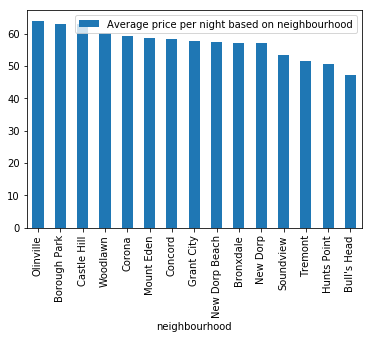

,Average price per night based on neighbourhood
neighbourhood,
Olinville,64.000000
Borough Park,63.066176
Castle Hill,63.000000
Woodlawn,60.090909
Corona,59.171875
Mount Eden,58.500000
Concord,58.192308
Grant City,57.666667
New Dorp Beach,57.400000


In [22]:
print('Least expensive neighbourhood according to Airbnb listing are')
df4 = dataset.dropna(subset=["price"]).groupby("neighbourhood")[["neighbourhood", "price"]].agg("mean").sort_values(by="price",
                                                                                                              ascending=False).rename(index=str, columns={"price": "Average price per night based on neighbourhood"}).tail(15)

df4.plot(kind='bar')
plt.show()
pd.DataFrame(df4)

**Most number of locality listed**

We will now try to figure out how many number of neighbourhood has been posted based on the count. We can see Williamsburg has most number of listing count where as Fort Wadesworth has one of the least listing i.e 1. 

I have listed below the listing of top 15 as well as least 15 based on the neighbourhood.

If we recall this neighbourhood is one of the highest stay based on price so this can be one of the reason that the price is increased due to the less number of listing.


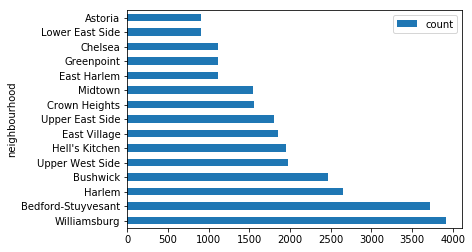

,count
neighbourhood,
Williamsburg,3919
Bedford-Stuyvesant,3714
Harlem,2656
Bushwick,2464
Upper West Side,1970
Hell's Kitchen,1955
East Village,1853
Upper East Side,1797
Crown Heights,1563


In [23]:

df5 = dataset.groupby('neighbourhood')[['neighbourhood','host_name']].agg(['count']
                                                                   )['host_name'].sort_values(by='count',ascending=False).rename(index=str,columns={'Count':'Listing Count'})

df5.head(15).plot(kind='barh')
plt.show()
pd.DataFrame(df5.head(15))

Least Listing number of count


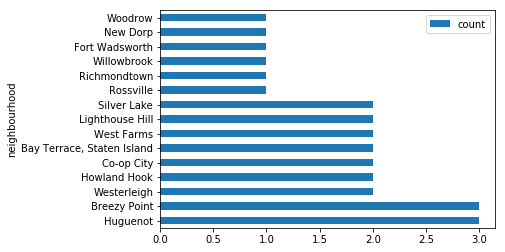

,count
neighbourhood,
Huguenot,3
Breezy Point,3
Westerleigh,2
Howland Hook,2
Co-op City,2
"Bay Terrace, Staten Island",2
West Farms,2
Lighthouse Hill,2
Silver Lake,2


In [24]:
print('Least Listing number of count')
df5 = dataset.groupby('neighbourhood')[['neighbourhood','host_name']].agg(['count']
                                                                   )['host_name'].sort_values(by='count',ascending=False).rename(index=str,columns={'Count':'Listing Count'})

df5.tail(15).plot(kind='barh')
plt.show()
pd.DataFrame(df5.tail(15))

**Location and Review Score**

Review is the one of the important criteria with online activity these days. This gives a lot of insights to a particular place for tourist and they can swing mood when it comes to online booking. A cheap place with bad review can drive a tourist for not booking and an expensive place with nicest review can shell a tourist more than what he have thought initially. So we will try to figure out the review , how each neighbourhood is doing in respect to review. Since there is a limited data with review we will try to figure out as much as we can.

First criteria of our review is we will consider only those who have a review more than 50, so that we can have an insight of the data.

So according to the below plot, Brooklyn got most review in comparison to Manhattan and that is an interesting find. Also Staten Island which is cheaper has less review than the other neighbourhood group. We cannot proceed further to understand why is that case since we have a limited data.


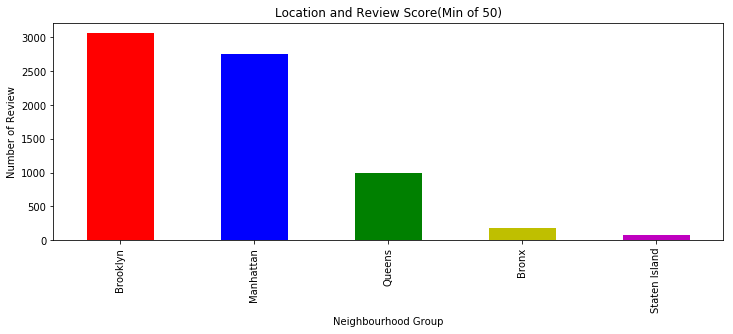

 Count of Review v/s neighbourhood group


,neighbourhood_group
Brooklyn,3065
Manhattan,2751
Queens,997
Bronx,187
Staten Island,81


In [25]:
fig = plt.figure(figsize=(12,4))
review_50 = dataset[dataset['number_of_reviews']>=50]
df2 = review_50['neighbourhood_group'].value_counts()
df2.plot(kind='bar',color=['r','b','g','y','m'])
plt.title('Location and Review Score(Min of 50)')
plt.ylabel('Number of Review')
plt.xlabel('Neighbourhood Group')
plt.show()
print(' Count of Review v/s neighbourhood group')
pd.DataFrame(df2)

**Top 5 host**

Based on the review score(Minimum 50) we will plot, who is our top 5 Host, this increases the confidence of tourist before booking.

Also lets plot based on the lattitude and location of our review data.



In [26]:
map1=folium.Map([40.7128,-74.0080],zoom_start=9.8)
location = ['latitude','longitude']
df = review_50[location]
HeatMap(df.dropna(),radius=8,gradient={.4: 'blue', .65: 'lime', 1: 'red'}).add_to(map1)
map1

Below plot shows the Top 5 host and it looks like Michael has received more reviews for topping the chart .

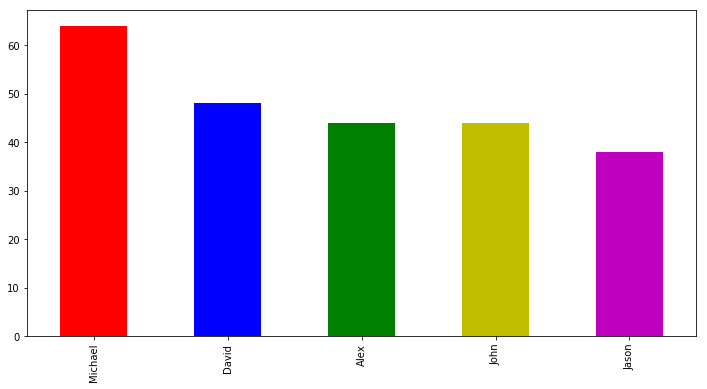

In [27]:
plt.figure(figsize=(12,6))
review_50.head(2)
df1 = review_50['host_name'].value_counts()[:5].plot(kind='bar',color=['r','b','g','y','m'])
#sns.barplot(x=df1.index,y=df1.values)


**Plot Price based on the Availability 365**

We will plot a scatterplot to understand if there is any price increase based on the availability and looking below the plot its hardly to infer. But looks like with availability with 365 the price increases to 10K.

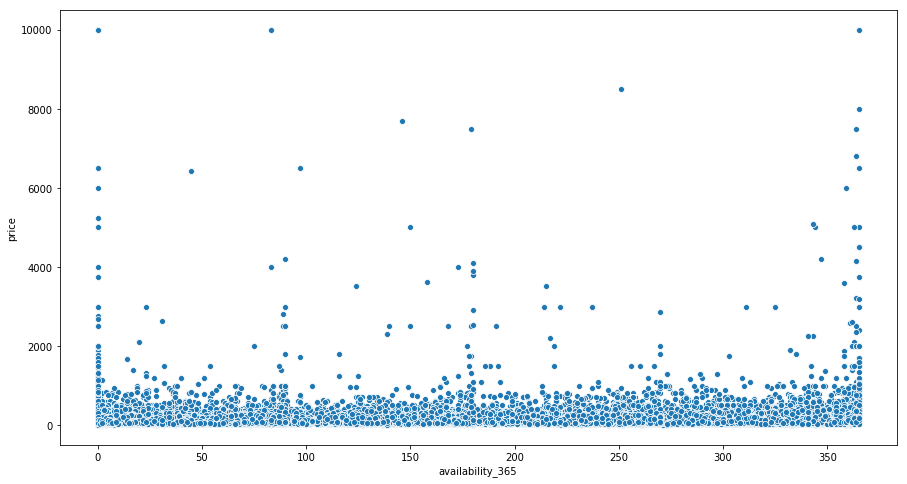

In [28]:
plt.figure(figsize=(15,8))
sns.scatterplot(y=dataset['price'],x=dataset['availability_365'])

**Average Listing for each Neighbourhood group**

In [29]:
df6 = review_50.groupby(['neighbourhood_group','room_type']).mean()
df6 = df6.drop(['id','calculated_host_listings_count','reviews_per_month'],axis=1)
pd.DataFrame(df6).sort_values('neighbourhood_group')

host_id   latitude  longitude  \
neighbourhood_group room_type                                             
Bronx               Entire home/apt  6.834402e+07  40.845571 -73.874436   
                    Private room     5.771343e+07  40.848007 -73.894449   
                    Shared room      8.610883e+07  40.840340 -73.830070   
Brooklyn            Entire home/apt  3.800371e+07  40.681820 -73.950473   
                    Private room     3.718687e+07  40.684031 -73.948452   
                    Shared room      3.795770e+07  40.668842 -73.941362   
Manhattan           Entire home/apt  3.753960e+07  40.760908 -73.975440   
                    Private room     4.220649e+07  40.776921 -73.968273   
                    Shared room      7.222840e+07  40.772727 -73.972424   
Queens              Entire home/apt  6.497462e+07  40.728087 -73.864378   
                    Private room     7.468608e+07  40.733657 -73.863445   
                    Shared room      9.552170e+07  40.716744 -73.843495   
Staten Island       Entire home/apt  7.416233e+07  40.615301 -74.098382   
                    Private room     5.922092e+07  40.622883 -74.096828   

                                          price  minimum_nights  \
neighbourhood_group room_type                                     
Bronx               Entire home/apt  107.000000        2.212500   
                    Private room      53.132075        2.084906   
                    Shared room       20.000000        1.000000   
Brooklyn            Entire home/apt  158.782955        3.921023   
                    Private room      71.594192        2.731554   
                    Shared room       40.806452        1.967742   
Manhattan           Entire home/apt  218.531682        4.694829   
                    Private room      97.856049        3.114855   
                    Shared room       62.444444        1.916667   
Queens              Entire home/apt  124.053012        2.725301   
                    Private room      61.807356        2.402802   
                    Shared room       43.181818        1.363636   
Staten Island       Entire home/apt  105.652174        3.108696   
                    Private room      54.714286        2.857143   

                                     number_of_reviews  availability_365  
neighbourhood_group room_type                                             
Bronx               Entire home/apt         101.325000        197.387500  
                    Private room            100.566038        177.660377  
                    Shared room             116.000000          5.000000  
Brooklyn            Entire home/apt         109.513068        171.889773  
                    Private room            109.997645        155.525118  
                    Shared room             105.322581        163.258065  
Manhattan           Entire home/apt         106.798980        157.758194  
                    Private room            117.383614        144.607198  
                    Shared room              92.916667        170.402778  
Queens              Entire home/apt         104.643373        184.932530  
                    Private room            116.199650        187.637478  
                    Shared room             122.454545        170.727273  
Staten Island       Entire home/apt          95.065217        197.217391  
                    Private room            105.742857        270.742857